## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [3]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


# Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

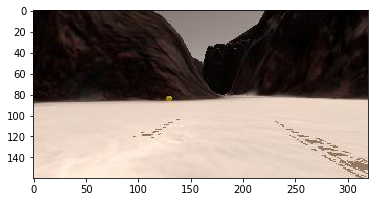

In [15]:
path = '../test_dataset/RunShort/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

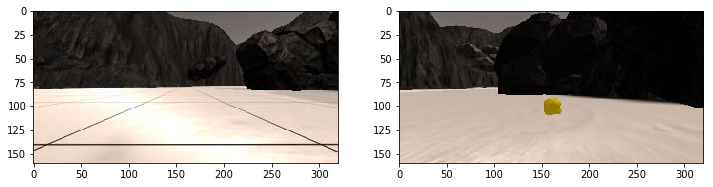

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

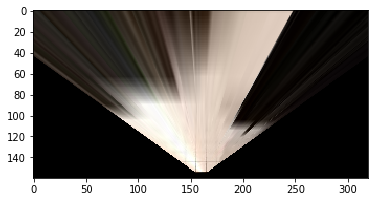

In [6]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
    """
    Convert an image from robot view, to birds-eye view.
    Uses OpenCV perspective transformations. Transforms the src box into the dst box
    
    Inputs:
        img:  nparray RGB image (doesn't have to be RGB)
        src:  pixel coordinates of initial box (Array of (x,y) pixel coords, cast as floats)
        dst:  pixel coordinates of destination box
    Returns:
        warped: nparray RGB image of bird-eye view
    """
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
# warped = perspect_transform(grid_img, source, destination)
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

uint8


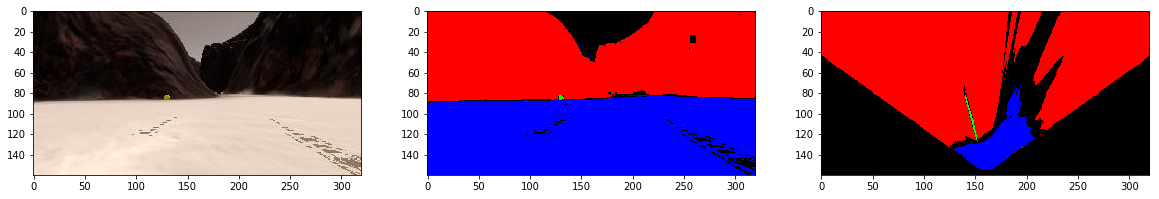

In [19]:
def color_thresh(img, nav_hi=(256,70,256),nav_lo=(0,0,180),
                      obs_hi=(256,256,90),obs_lo=(0,0,0),
                      rock_hi=(40,256,256),rock_lo=(25,140,120) ):
    """
    Classifies pixels as obstacle, rock, or navigable terrain using HSV color thresholding
    Thresholding in HSV space for better performance.
    Default values of high and low ranges experimentally determined.
    
    Inputs:
        img:       nparray of image (3 channel RGB)
    Kwargs:
        Tuples of high and low Hue, Saturaion, Value for each Obstacle, Rock, and Navigable classification
    Retuns:
        color_select:  3 chan RGB image binary image, with Red = Obs, Green = Rock, Blue = Navigable
    """
    # Hack to account for odd matplotlib HSV settings (H and S are 0.0-1.0, but V is 0-255 (?))
    nav_hi = (nav_hi[0]/255.0, nav_hi[1]/255.0, nav_hi[2])
    nav_lo = (nav_lo[0]/255.0, nav_lo[1]/255.0, nav_lo[2])
    obs_hi = (obs_hi[0]/255.0, obs_hi[1]/255.0, obs_hi[2])
    obs_lo = (obs_lo[0]/255.0, obs_lo[1]/255.0, obs_lo[2])
    rock_hi = (rock_hi[0]/255.0, rock_hi[1]/255.0, rock_hi[2])
    rock_lo = (rock_lo[0]/255.0, rock_lo[1]/255.0, rock_lo[2])

    # Convert RGB image to HSV (using matplotlib function)
    hsv_img = matplotlib.colors.rgb_to_hsv(img)

    # Apply threshholding (Low and High)
    nav = (hsv_img[:,:,0] >= nav_lo[0]) & (hsv_img[:,:,0] <= nav_hi[0]) & \
          (hsv_img[:,:,1] >= nav_lo[1]) & (hsv_img[:,:,1] <= nav_hi[1]) & \
          (hsv_img[:,:,2] >= nav_lo[2]) & (hsv_img[:,:,2] <= nav_hi[2])
    obs = (hsv_img[:,:,0] >= obs_lo[0]) & (hsv_img[:,:,0] <= obs_hi[0]) & \
          (hsv_img[:,:,1] >= obs_lo[1]) & (hsv_img[:,:,1] <= obs_hi[1]) & \
          (hsv_img[:,:,2] >= obs_lo[2]) & (hsv_img[:,:,2] <= obs_hi[2])
        # Don't include pure black pixels (just non-data from transform)
    obs_nonzero = (img[:,:,0] != 0) \
                | (img[:,:,1] != 0) \
                | (img[:,:,2] != 0) 
    obs = obs & obs_nonzero
    rock= (hsv_img[:,:,0] >= rock_lo[0]) & (hsv_img[:,:,0] <= rock_hi[0]) & \
          (hsv_img[:,:,1] >= rock_lo[1]) & (hsv_img[:,:,1] <= rock_hi[1]) & \
          (hsv_img[:,:,2] >= rock_lo[2]) & (hsv_img[:,:,2] <= rock_hi[2])

    # 3 Channel bool nparray of classification (obstacle, rock, navigable)
    color_select = np.dstack([obs, rock, nav])

    return color_select

def show_thresh(color_select):
    """
    Convert Boolean array to uint8 to show as image
    Inputs:
        color_select: 3 Channel Boolean array with Red = Obs, Green = Rock, Blue = Nav
    Returns:
        thresh:       3 Channel uint8 array  "         "          "      "
    """
    thresh = np.zeros_like(color_select,dtype=np.uint8)
    thresh[color_select] = 255
    return thresh
    
img_col_sel = color_thresh(image) # color thresh the initial image
img_thresh = show_thresh(img_col_sel)

print(img_thresh.dtype)

warped = perspect_transform(image, source, destination)
col_sel = color_thresh(warped) # color thresh the warped image
threshed = show_thresh(col_sel)
fig = plt.figure(figsize=(20,15))
plt.subplot(131)
plt.imshow(image)
plt.subplot(132)
plt.imshow(img_thresh)
plt.subplot(133)
plt.imshow(threshed)

# plt.savefig('../writeup_images/color_thresh.jpg')

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

Max/min theta: 40.60, -52.97
Min fron: 1.70
Rock pixes:  0
Len of right_inds: 693
Mean right dist: 56.24
Right dist: 9.22


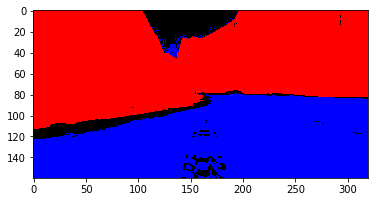

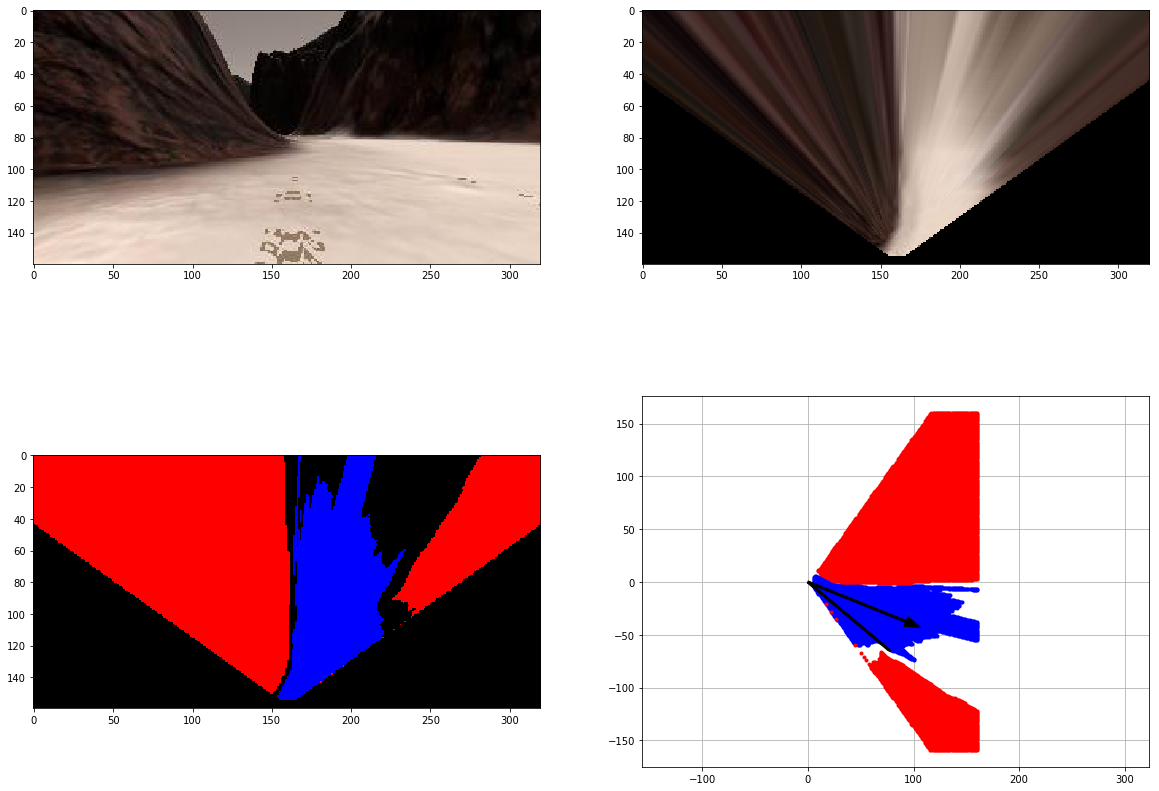

In [69]:
# Define a function to convert from image coords to rover coords
def rover_coords(color_sel):
    """
    Convert image view to robot coordinate system.
    
    Inputs:
        color_sel:  nparray RGB Bool array classiffying Obs, Rock, Nav in respective chans
    Returns:
        xnav_pix, ynav_pix:     Pixel indices of navigable terrain (in robot coord frame)
        xobs_pix, yobs_pix:        " "           obstacle    "       "
        xrock_pix, yrock_pix:      " "           rock        "       "
    """
    # Extract True indices
    ynav, xnav = np.where(color_sel[:,:,2])
    yobs, xobs = np.where(color_sel[:,:,0])
    yrock, xrock = np.where(color_sel[:,:,1])
    
    # Rotate to robot coordinate frame ("Forwards" is +x-axis, "Left" is +y-axis)
    xnav_pix = -(ynav - color_sel.shape[0]).astype(np.float)
    ynav_pix = -(xnav - color_sel.shape[1]/2).astype(np.float)
    xobs_pix = -(yobs - color_sel.shape[0]).astype(np.float)
    yobs_pix = -(xobs - color_sel.shape[1]/2).astype(np.float)
    xrock_pix = -(yrock - color_sel.shape[0]).astype(np.float)
    yrock_pix = -(xrock - color_sel.shape[1]/2).astype(np.float)
    
    return xnav_pix, ynav_pix, xobs_pix, yobs_pix, xrock_pix, yrock_pix
    

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    """
    Convert Cartesian to Polar coordinates (r,theta)
    (Useful for getting mean angle of naviagable terrain)
    Inputs:
        x_pixel:  nparray of x pixels
        y_pixel:  nparray of y pixels
    Returns:
        r, th:    Radius and angle (rad)
    """
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    r = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    th = np.arctan2(y_pixel, x_pixel) # in radians
    
    print("Max/min theta: %.2f, %.2f"%(np.rad2deg(np.max(th)),np.rad2deg(np.min(th))))
    
    return r, th

def pix_to_world(navx, navy, obsx, obsy, rockx, rocky, xpos, ypos, yaw, scale, tile_size):
    """
    Converts Rover-centric to global position (rotate and scale to fit worldmap, no translation yet)
    Inputs:
        xnav_pix, ynav_pix:     Pixel indices of navigable terrain (in robot coord frame)
        xobs_pix, yobs_pix:        " "           obstacle    "       "
        xrock_pix, yrock_pix:      " "           rock        "       "
        xpos, ypos:             Absolute location of rover (bounded within world size, so 0-200)
        yaw:                    Robot heading (radians)
        scale:                  Scaling factor from pixels to meters (10 pixels = 1 meter)
        tile_size:              Size of return tile in pixels (equivalently meters)
    Returns:
        tile:                   RGB nparray of classifications. Robot centered in tile, which is 
                                typically 50m x 50m. Need to add tile to worldmap_sum by translating,
                                and clipping
    """
    # Conver to radians
    th = yaw * np.pi / 180
    # Rotate
    navx_rot = navx*np.cos(th) - navy*np.sin(th)
    navy_rot = navx*np.sin(th) + navy*np.cos(th)
    obsx_rot = obsx*np.cos(th) - obsy*np.sin(th)
    obsy_rot = obsx*np.sin(th) + obsy*np.cos(th)
    rockx_rot = rockx*np.cos(th) - rocky*np.sin(th)
    rocky_rot = rockx*np.sin(th) + rocky*np.cos(th)

    # Scale
    navx_tran = (navx_rot / scale)
    navy_tran = (navy_rot / scale)
    obsx_tran = (obsx_rot / scale)
    obsy_tran = (obsy_rot / scale)
    rockx_tran = (rockx_rot / scale)
    rocky_tran = (rocky_rot / scale)

    # Shift center to middle of small tile
    nx = np.int_(navx_tran + tile_size//2)
    ny = np.int_(navy_tran + tile_size//2)
    ox = np.int_(obsx_tran + tile_size//2)
    oy = np.int_(obsy_tran + tile_size//2)
    rx = np.int_(rockx_tran + tile_size//2)
    ry = np.int_(rocky_tran + tile_size//2)
    
    # Create tile (custom, hard-coded weights for classifications)
    tile = np.zeros((tile_size, tile_size, 3),dtype=np.uint8)
    tile[ny,nx,2] = 10
    tile[oy,ox,0] = 10
    tile[ry,rx,1] = 255 # Don't see rocks often, so weight it higher to not miss it

    return tile

def apply_tile_blur(tile, circle_blur):
    """
    Blur the classification tile by radial distance from robot.
    (Less confident in pixels "further" away)
    Inputs:
        tile:  Classification tile (nparray 3 chan RGB)
        circle_blur:   "kernel" tile of same shape, with circular gradient (1 in center, fades to 0)
    Returns:
        blur:  Blurred Classification tile
    """
    blur = np.multiply(tile,circle_blur).astype(np.uint8)
    return blur
    

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
col_sel = color_thresh(warped)
threshed = show_thresh(col_sel)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
navx, navy, obsx, obsy, rockx, rocky = rover_coords(threshed)
dist_nav, ang_nav = to_polar_coords(navx, navy)
mean_dir = np.mean(ang_nav)

# Check the +/- 0.6 m channel in front of rover
front_inds = (obsy < 6) & (obsy > -6)
if(np.any(front_inds)):
    front_dist = np.min(obsx[front_inds]) / 10.0
    print("Min fron: %.2f"%front_dist)
else:
    print("No obstacles in front  :)")

    
print("Rock pixes: ",len(rockx))

right_inds = (ang_nav < np.deg2rad(-40))
print("Len of right_inds: %d"%np.sum(right_inds))
# if(np.sum(right_inds) != 0):
if(np.any(right_inds)):
    mean_right_dist = np.mean(dist_nav[right_inds])
    print("Mean right dist: %.2f"%mean_right_dist)
    right_dist = np.min(dist_nav[right_inds])
    print("Right dist: %.2f"%right_dist)
else:
    print("No navigable terrain to the right!")

# Constants
tile_size = 50
world_size = 200
scale = 10

# Randomly choose pose to test pix_to_world
yaw = np.random.random(1)*360
xpos = np.random.random(1)*160 + 20
ypos = np.random.random(1)*160 + 20
tile = pix_to_world(navx, navy, obsx, obsy, rockx, rocky, xpos, ypos, yaw, scale, tile_size)


img_col_sel = color_thresh(image)
img_thresh = show_thresh(img_col_sel)
plt.figure()
plt.imshow(img_thresh)
    
# Do some plotting
fig = plt.figure(figsize=(20,15))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed)
plt.subplot(224)
plt.plot(navx, navy, 'b.')
plt.plot(obsx, obsy, 'r.')
plt.plot(rockx, rocky, 'g.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.axis('equal')
plt.grid(True)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='black', zorder=2, head_width=10, width=2)

x45 = arrow_length * np.cos(np.deg2rad(-40))
y45 = arrow_length * np.sin(np.deg2rad(-40))
plt.arrow(0, 0, x45, y45, color='black', zorder=2, head_width=2, width=2)


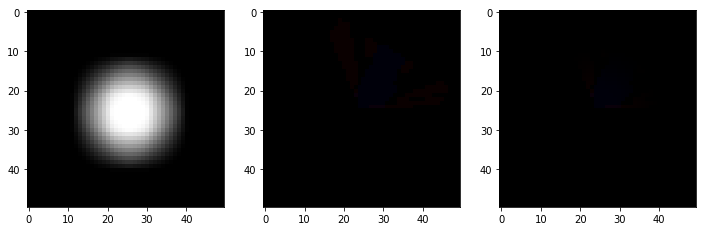

In [34]:
# Test blurring step, using circle gradient on the worldmap tile

# Create gradient blurrer
cir = np.zeros((tile_size, tile_size, 3), dtype=float)
cv2.circle(cir,(cir.shape[1]//2,cir.shape[0]//2), 10, color=(1,1,1), thickness=-1)
cir = cv2.blur(cir, (10,10))
# Blur tile
tile_blur = apply_tile_blur(tile, cir)
# tile_blur = tile


fig = plt.figure(figsize=(12,9))
plt.subplot(131)
plt.imshow(cir, cmap='gray')
plt.subplot(132)
plt.imshow(np.flipud(tile)) # May be very dark, hard to see, because not normalized
plt.subplot(133)
plt.imshow(np.flipud(tile_blur))


## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [13]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
df = pd.read_csv('../test_dataset/Run2/robot_log.csv', delimiter=';', decimal='.')
# df = pd.read_csv('../robot_log.csv', delimiter=';', decimal='.')

csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.roll = df["Roll"].values
        self.pitch = df["Pitch"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.worldmap_sum = np.zeros((200, 200, 3)).astype(np.float)
        self.worldmap_path = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [14]:
def update_worldmap(worldmap, worldmap_sum, tile, xpos, ypos, roll, pitch):
    """
    Given a tile of the newest observation, update the worldmap by accumulating the classifications, then
    taking the dominant class (Obstacle, Rock, or Navigable) for the update pixels.
    Inputs:
        worldmap:      3 chan RGB nparray image, with binary (technically trinary(?)) classification of terrain
        worldmap_sum:  3 chan RGB nparray image with accumulated sum of previous classifications
        tile:          most recent observation/classification of terrian
        xpos, ypos:    Global location of robot (bounded by worldsize, ex 0-200m)
    Returns:
        worldmap:      Newly adjust classifications of the given region of interest
    """
    # Only update, if roll and pitch are good
    if( (abs(roll-180) < 179) | (abs(pitch-180) < 179) ):
        return worldmap
    
    # Constants
    tile_size = tile.shape[0]
    offset = tile_size//2
    world_size = worldmap_sum.shape[0]
    
    # Define slicing index for worldmap
    x1 = np.int_(np.floor(xpos-offset))
    x2 = np.int_(np.floor(xpos+offset))+tile_size%2 # Hack for odd sizes
    y1 = np.int_(np.floor(ypos-offset))
    y2 = np.int_(np.floor(ypos+offset))+tile_size%2 
    
    # Define slicing index for tile (in case part of tile lies off the edge of worldmap)
    x1t, y1t = 0,0
    x2t, y2t = tile_size, tile_size
   
    # Adjust for edges
    if(x1 < 0):
        x1t = -x1
        x1 = 0
    if(y1 < 0):
        y1t = -y1
        y1 = 0
    if(x2 > world_size):
        x2t = -(x2-world_size)
        x2 = world_size
    if(y2 > world_size):
        y2t = -(y2-world_size)
        y2 = world_size
     
    # Accumulate classification
    #    Sum th
    tile_slice = tile[y1t:y2t , x1t:x2t]
    worldmap_sum[y1:y2 , x1:x2] += tile_slice
    
    # Only need to consider non-zero indexes
    indy, indx = np.where( (tile_slice[:,:,0]!=0) \
                         | (tile_slice[:,:,1]!=0) \
                         | (tile_slice[:,:,2]!=0) )    
    # Adjust offset
    indy +=  int(y1)
    indx +=  int(x1)

                     
    # Loop through each pixel, and chose most dominant color value
    # Ex: If the worldmap_sum pixel (25,37) has RGB = (100,534,23),
    #     then color it Green, because most dominant color
    for i in range(len(indx)):
        yi, xi = indy[i], indx[i]
        chan = np.argmax(worldmap_sum[yi,xi])
        worldmap[yi,xi] = (0,0,0)
        worldmap[yi,xi,chan] = 255
    
    return worldmap
    

In [15]:
##### # Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 1] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 2] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 0] += 1

    # 7) Make a mosaic image, below is some example code

    tile_size = 50
    world_size = 200
    scale = 10
    
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    col_sel = color_thresh(warped)
    threshed = show_thresh(col_sel)
    y = img.shape[0]
    x = data.worldmap.shape[1]+tile_size
    output_image[y:y+threshed.shape[0], x:x+threshed.shape[1]] = threshed

    # Calculate pixel values in rover-centric coords and distance/angle to all pixels
    navx, navy, obsx, obsy, rockx, rocky = rover_coords(col_sel)
    dist_nav, ang_nav = to_polar_coords(navx, navy)
    mean_dir = np.mean(ang_nav)
    

    # Load pos and angle
    xpos, ypos, yaw = data.xpos[data.count], data.ypos[data.count], data.yaw[data.count]
    roll, pitch = data.roll[data.count], data.pitch[data.count]
    
    # NEW: 
    intx, inty = int(xpos), int(ypos)
    data.worldmap_path[inty, intx] = (255,255,255)
#     whitex = [intx, intx, intx, intx-1, intx+1]
#     whitey = [inty, inty+1, inty-1, inty, inty]
#     data.worldmap_path[whitey, whitex] = (255,255,255)

    # Calc dist to right wall using global map
    # Do some line math
    x1, y1 = intx, inty
    th = yaw - 90
    height, width = data.worldmap.shape[0], data.worldmap.shape[1]
    
    # Initialize right_dist to -1, which indicates if no wall found
    right_dist = -1
    # If right wall is straight up
    if(th == 90):
        x = x1
        for y in range(y1,0,-1): # Check pixels, going upwards
            if (data.worldmap[y,x,0] != 0): # Check if obstacle
                right_dist = y1 - y
                break 
    # If right wall is straight down
    elif(th == 270):
        x = x1
        for y in range(y1, height): # Check downwards
            if(data.worldmap[y,x,0] != 0):
                right_dist = y - y1
                break
    # If right wall is westwards
    elif((th > 90) & (th < 270)):
        m = np.tan(th) # Calc slope
        for x in range(x1, 0, -1): # Check leftwards
            y = np.int(y1 + m*(x-x1))
            if( (y < 0) | (y >= height)): # Make sure y not out of bnounds
                break
            else: # Still in bounds, so check if wall
                if(data.worldmap[y,x,0] != 0):
                    right_dist = np.sqrt( (x-x1)**2 + (y-y1)**2 )
                    break
    # If right wall is eastwards
    else:
        m = np.tan(th) # Calc slope
        for x in range(x1, width): # Check rightward
            y = np.int(y1 + m*(x-x1))
            if( (y < 0) | (y >= height)):
                break
            else:
                if(data.worldmap[y,x,0] != 0):
                    right_dist = np.sqrt( (x-x1)**2 + (y-y1)**2 )
                    break
        

    cv2.putText(output_image,"Right Dist: %f" %right_dist,(200, 200),
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    
    
    
    # Extract world coordinates of navigable, obstacle, and rock
    tile = pix_to_world(navx, navy, obsx, obsy, rockx, rocky, xpos, ypos, yaw, scale, tile_size)

    # Create circle gradient blur
    # Already done above, called cir
    
    # Blur tile
    tile_blur = apply_tile_blur(tile, cir)
#     tile_blur = tile
    output_image[img.shape[0]:img.shape[0]+tile_size, data.worldmap.shape[1]:data.worldmap.shape[1]+tile_size] = tile_blur
    
    # Update worldmap with tile
    data.worldmap = update_worldmap(data.worldmap, data.worldmap_sum, tile_blur, xpos, ypos, roll, pitch)

    
        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    map_add = cv2.addWeighted(map_add, 1, data.worldmap_path, 0.5, 0)
    
#     print("worldmap range: %d, %d" %(np.min(data.worldmap),np.max(data.worldmap)))
#     print("ground truth range: %d, %d" %(np.min(data.ground_truth),np.max(data.ground_truth)))
    
#     map_add = cv2.addWeighted(data.worldmap_sum, 1, data.ground_truth, 0, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [34]:
# Import everythi += 10
#     data.worldmap[ry_w, rx_w, 1] +=worldmap 10
#     data.worldmap[ny_w, nx_w, 2] += 10
#     data.worldmap = np.clip(data.wng needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 519/519 [00:18<00:00, 28.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

Wall time: 18.5 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [35]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [36]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))